In [10]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [36]:
train_dataset = torchvision.datasets.CelebA(root="../data", split="train", transform=ToTensor(), download=True, target_transform=None)
test_dataset = torchvision.datasets.CelebA(root="../data", split="test", transform=ToTensor(), download=True, target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


AttributeError: 'CelebA' object has no attribute 'class_to_idx'

In [49]:
class_to_idx = train_dataset.attr_names[:-1]
len(class_to_idx)

40

In [11]:
train_dataset = DataLoader(train_dataset, 32, True)
test_dataset = DataLoader(test_dataset, 32, shuffle=False)

In [35]:
batch, images = next(iter(train_dataset))
batch.shape, images.shape

(torch.Size([32, 3, 218, 178]), torch.Size([32, 40]))

torch.Size([3, 218, 178])
torch.Size([218, 178, 3])
torch.Size([40])
The person has/is: Arched_Eyebrows
The person has/is: Attractive
The person has/is: Big_Lips
The person has/is: No_Beard
The person has/is: Pale_Skin
The person has/is: Wavy_Hair
The person has/is: Wearing_Lipstick
The person has/is: Young


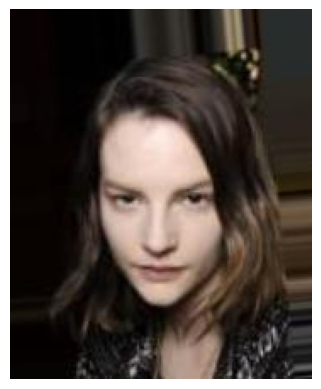

In [50]:
print(batch[0].shape)
permuted = batch[0].permute(1, 2, 0)
print(permuted.shape)
plt.imshow(permuted) # imshow requires this order (Width, Height, Color channels)
plt.axis(False)
print(images[0].shape)
features = list(images)
for i in range(len(class_to_idx)):
    if (images[0][i] == 1):
        print("The person has/is: %s" % (class_to_idx[i]))